# Portfolio Pipeline on a ticker based level

Visualization of single ticker developement


In [1]:
from credentials import api_key

In [2]:
def get_nearest_date(items, pivot):
    """
    Finds the nearest date in a list of date strings to a given pivot date.
    (source: https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date)
    :param items: (list of str) A list containing date strings in the format "%Y-%m-%d".
    :param pivot: (str) The date string in the format "%Y-%m-%d" to which the nearest date is sought.
    :return: nearest (datetime): The nearest datetime object to the pivot date.
            timedelta (timedelta): The time difference between the nearest date and the pivot date.
    """
    if pivot is None:
        return None, None

    # Convert the date strings to datetime objects
    items = [datetime.strptime(date, "%Y-%m-%d") for date in items if type(date) == str]

    if type(pivot) == str:
        pivot = datetime.strptime(pivot, "%Y-%m-%d")


    if not items:
        return None, None

    nearest = min(items, key=lambda x: abs(x - pivot))
    timedelta = abs(nearest - pivot)
    return nearest, timedelta



def get_closing_price(ticker: str, target_date: str):
    """
    Get the closing price of a ticker on a given target date.
    If there is no possible way through an API, the function returns the nearest closing price.
    :param ticker: ticker symbol as string
    :param target_date: target date as string
    :return: (nearest) closing price as float
    """

    closing_price = None

    alpha_vantage_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={api_key}&datatype=csv'
    alpha_vantage_csv = pd.read_csv(alpha_vantage_url)
    alpha_vantage_df = pd.DataFrame(alpha_vantage_csv)

    # Try fetching from Alpha Vantage
    for index, row in alpha_vantage_df.iterrows():
        if row['timestamp'] == target_date:
            closing_price = row['close']
            # print(f"Found exact match in Alpha Vantage: {closing_price}")
            return closing_price

    if closing_price is None:
        print(f'Not exact date for {ticker}')
        # find the nearest closing price
        dates = alpha_vantage_df['timestamp']
        nearest_date, timedelta = get_nearest_date(dates, target_date)

        # Check if nearest_date is None
        if nearest_date is None:
            return None

        # Get closing price of nearest date
        nearest_date_str = nearest_date.strftime("%Y-%m-%d")
        for index, row in alpha_vantage_df.iterrows():
            if row['timestamp'] == nearest_date_str:
                nearest_closing_price = row['close']
                # print(f"Found nearest closing price: {nearest_closing_price} on {nearest_date_str}")
                return nearest_closing_price
    else:
        return closing_price


In [3]:
import pandas as pd
import zipfile

def get_key_metrics(zip_file_path: str, ticker: str):
    """
    Retrieves key metrics for the given ticker symbol from a JSON file within a zip folder.

    :param zip_file_path: File path of the zip folder containing the key_metrics.json file.
    :param ticker: Ticker symbol as a string.
    :return: Pandas DataFrame containing key metrics for the given ticker symbol.
    """
    file_name = f'{ticker}_key-metrics.json'

    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            with zip_ref.open(file_name) as file:
                content = pd.read_json(file)
                return content
    except FileNotFoundError:
        print(f"File {file_name} not found in the provided zip folder path: {zip_file_path}")
        return pd.DataFrame()  # Returning an empty DataFrame on file not found
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [6]:
from util import get_quarters_df

quarters_df = get_quarters_df()
print(quarters_df)
end_dates = [row['date'].strftime("%Y-%m-%d") for index, row in quarters_df.iterrows()]
end_dates = end_dates[1:]
print(end_dates)

         date quarter  year
0  1999-12-31      Q4  1999
1  2000-03-31      Q1  2000
2  2000-06-30      Q2  2000
3  2000-09-30      Q3  2000
4  2000-12-31      Q4  2000
..        ...     ...   ...
88 2021-12-31      Q4  2021
89 2022-03-31      Q1  2022
90 2022-06-30      Q2  2022
91 2022-09-30      Q3  2022
92 2022-12-31      Q4  2022

[93 rows x 3 columns]
['2000-03-31', '2000-06-30', '2000-09-30', '2000-12-31', '2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31', '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31', '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31', '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31', '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31', '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31', '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31', '2011-06-3

In [7]:
import math

def calculate_gn_with_avg_eps(ticker, target_date):

    # Get key metrics
    key_metrics = get_key_metrics('../key-metrics.zip', ticker)

    # Define the time window based on the quarter of the target date
    target_date = pd.to_datetime(target_date)
    quarter_start_month = (target_date.month - 1) // 3 * 3 + 1
    start_date = pd.to_datetime(f'{target_date.year}-{quarter_start_month:02d}-01')
    end_date = start_date + pd.DateOffset(months=3, days=-1)

    for index, row in key_metrics.iterrows():
        date = pd.to_datetime(row['date'])

        # Check if the date is within the desired time window
        if start_date <= date <= end_date:
            # Extract EPS values for the last three years
            eps_values = \
            key_metrics.loc[(key_metrics['date'] >= date - pd.DateOffset(years=3)) & (key_metrics['date'] <= date)][
                'netIncomePerShare']

            # Calculate the average EPS over the last three years
            avg_eps = eps_values.mean()

            bvps = row['bookValuePerShare']

            # Check if avg_eps and bvps are non-negative before calculating Graham number
            if avg_eps >= 0 and bvps >= 0:
                graham_number = math.sqrt(22.5 * avg_eps * bvps)
                print(f'The calculated Graham number on {target_date} is {graham_number}')
                return graham_number

            else:
                '''graham_number = row['grahamNumber']
                print("Average EPS or BVPS is negative. Took the given Graham Number instead of calculating it.")
                return graham_number'''
                return None

In [8]:
from datetime import datetime

ticker = 'AAPL'

graham_dict = {}
price_dict = {}

for quarter in end_dates:

    graham_num = calculate_gn_with_avg_eps(ticker, quarter)
    graham_dict[quarter] = graham_num

    price = get_closing_price(ticker, quarter)
    price_dict[quarter] = price

print(graham_dict)
print(price_dict)

The calculated Graham number on 2000-06-30 00:00:00 is 0.16478697132073628
The calculated Graham number on 2000-09-30 00:00:00 is 0.20330572623801418
Not exact date for AAPL
The calculated Graham number on 2000-12-31 00:00:00 is 0.17918748499814127
Not exact date for AAPL
The calculated Graham number on 2001-03-31 00:00:00 is 0.1759468615420047
Not exact date for AAPL
The calculated Graham number on 2001-06-30 00:00:00 is 0.17421803394919447
Not exact date for AAPL
The calculated Graham number on 2001-09-30 00:00:00 is 0.1710378989791572
Not exact date for AAPL
The calculated Graham number on 2001-12-31 00:00:00 is 0.16289630598032048
The calculated Graham number on 2002-03-31 00:00:00 is 0.15524397309489188
Not exact date for AAPL
The calculated Graham number on 2002-06-30 00:00:00 is 0.1414953199292777
Not exact date for AAPL
The calculated Graham number on 2002-09-30 00:00:00 is 0.1296463240272495
The calculated Graham number on 2002-12-31 00:00:00 is 0.12445512092025478
The calcula

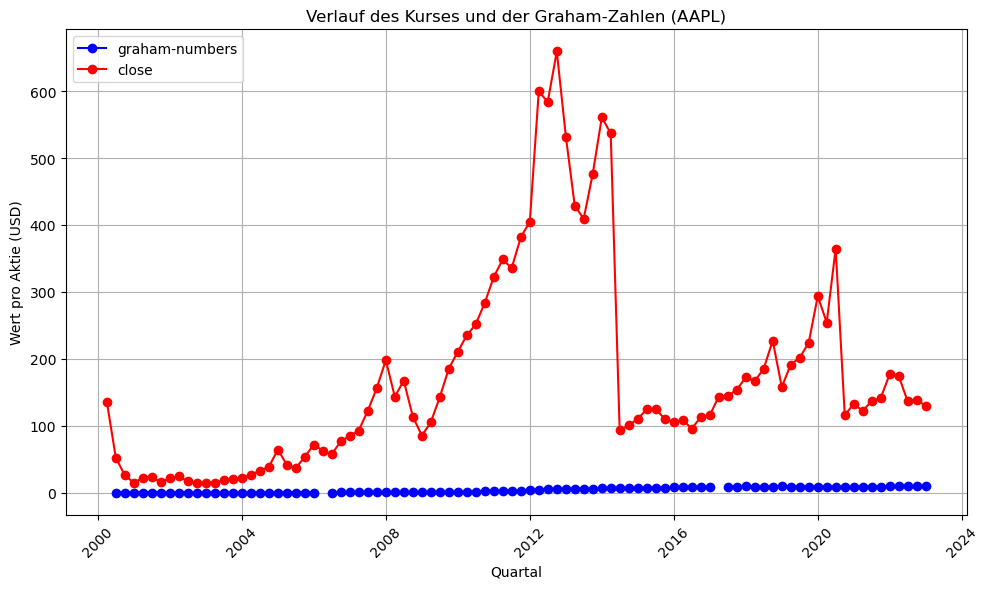

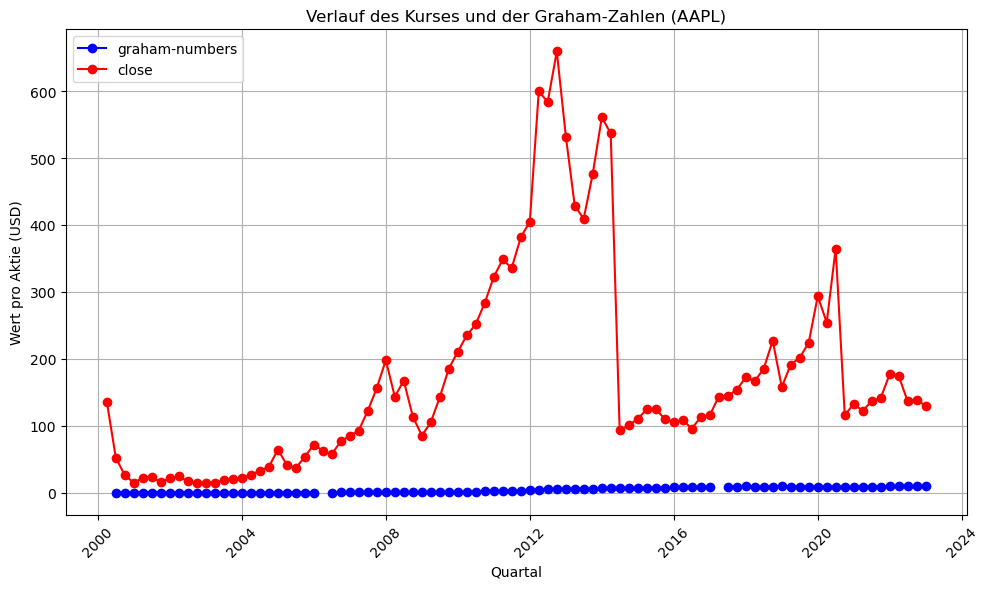

In [10]:
from datetime import datetime
import matplotlib.pyplot as plt

end_dates = [datetime.strptime(date, "%Y-%m-%d") for date in graham_dict.keys()]

graham_numbers = list(graham_dict.values())
prices = list(price_dict.values())

plt.figure(figsize=(10, 6))
# portfolio graph
plt.plot(end_dates, graham_numbers, marker='o', linestyle='-', color='b', label='graham-numbers')
# s&p graph
plt.plot(end_dates, prices, marker='o', linestyle='-', color='r', label='close')
plt.title(f'Verlauf des Kurses und der Graham-Zahlen ({ticker})')
plt.xlabel('Quartal')
plt.ylabel('Wert pro Aktie (USD)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.savefig(f'portfolio_visualizations/graham_price_{ticker}')

plt.show()
